In [38]:
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import math as m
from helper import batch_sampler, batcher, make_features, PE

In [2]:
electricity_df = pd.read_csv('/Users/omernivron/Downloads/electricity.csv')

In [3]:
electricity_df
## Notice that every numbered column represents a different client 

,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,OT
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
26300,2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
26301,2019-07-01 23:00:00,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0
26302,2019-07-02 00:00:00,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,...,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0,2719.0


In [4]:
## We will need the date information in a numeric version 
def date_to_numeric_feats(col):
    datetime = pd.to_datetime(electricity_df.date)
    return datetime.dt.hour, datetime.dt.day, datetime.dt.month, datetime.dt.year

In [5]:
electricity_df['hr'], electricity_df['day'], electricity_df['month'], electricity_df['year']= date_to_numeric_feats(electricity_df.date)

In [6]:
electricity_df_hr = electricity_df.groupby(["year","month", "day", "hr"]).mean().reset_index()

In [7]:
electricity_df_hr['t'] = electricity_df_hr['year'] + ((electricity_df_hr['month'] - 1)/ 12) + (electricity_df_hr['day'] - 1)/ (12 *31) + electricity_df_hr['hr']/(24*31*12)


In [8]:
### We will pick client #300 for the tutorial 
client_300 = electricity_df_hr.loc[:, ["300", "t"]].reset_index(drop=True)

In [9]:
k = int((client_300["300"].shape[0]) * 0.7)
t, y = batcher(client_300["t"][:18142], client_300["300"][:18142], batch_s=32)
t.shape # (1, 288)
y.shape # (1, 288, 1)

(32, 288)

In [10]:
t, y, m, n = batch_sampler(t, y)

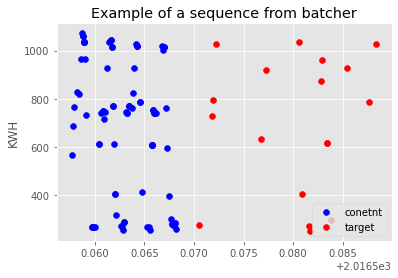

In [11]:
plt.scatter(t[0, :int(m)], y[0, :int(m)], label='conetnt', c='blue')
plt.scatter(t[0, int(m):], y[0, int(m):], label='target', c='red')
plt.ylabel('KWH')
plt.title("Example of a sequence from batcher")
plt.legend()
plt.show()

### the ATP model

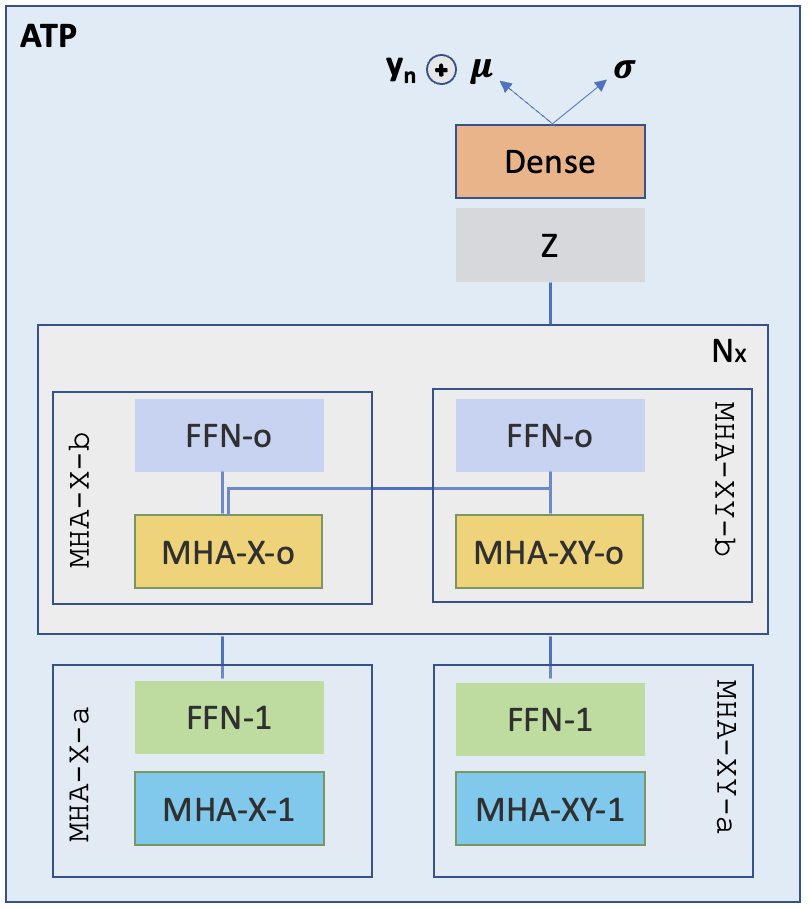

In [48]:
display(Image('ATP-v2.png', width=500, height=500))

#### MHA-X-1

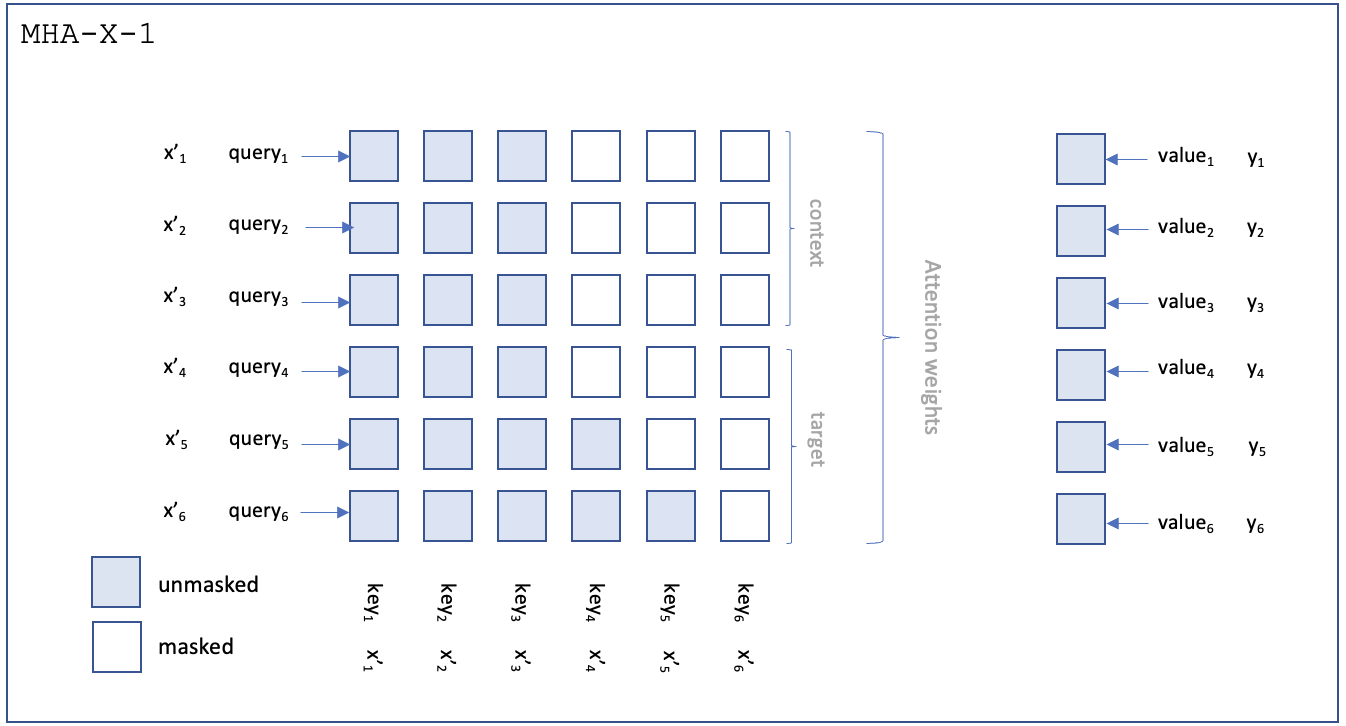

In [13]:
display(Image('MHA-X-1.png', width=750, height=750))

* a square represents the dot-product between the row and column elements

From the paper
$x′_i = (PE(x_i), PE(x_{n(i)}), PE(x_i) − P E(x_{n(i)}))$

where $PE$ is the positional embedding function 

and $x_{n(i)}$ is the closest available point to $x_i$ 

##### Example to calculate x' 

let's choose 6 points as in the image above.

The first 3 will be context points --- 
in the paper symbols this means $n_c = 3$ and $n_T = 3$

In [14]:
t_ex = t[0, :6]
y_ex = y[0, :6]
n_c = 3
n_T = 3
d = 28

In [15]:
diff_x = np.zeros((n_c + n_T, d))
x_n = np.zeros((n_c + n_T, d))

for j in range(n_c):
    current_x = t_ex[:n_c][j]
    x_temp = t_ex[:n_c]
    ix = np.argsort(np.abs(current_x - x_temp))[1] 
    diff_x[j, :] = PE(np.array([current_x])[:, np.newaxis]) -  PE(np.array([x_temp[ix]])[:, np.newaxis])
    x_n[j, :] = PE(np.array([x_temp[ix]])[:, np.newaxis])
        
for j in range(n_c, n_T):

    x_temp = t_ex[:j+1]
    ix = np.argmin(np.abs(x_temp[-1] - x_temp[:-1]))
    diff_x[j, :] = PE(np.array([x_temp[-1]])[:, np.newaxis]) -  PE(np.array([x_temp[ix]])[:, np.newaxis])
    x_n[j, :] = PE(np.array([x_temp[ix]])[:, np.newaxis])

In [16]:
x_prime = np.concatenate([PE(t_ex[:, np.newaxis]).squeeze(), x_n, diff_x], axis=-1)

##### 

In [14]:
class MHA_X_1(tf.keras.layers.Layer):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1):
        super(MHA_X_1, self).__init__()
        self.key_dim = key_dim
        self.num_heads = num_heads
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim = key_dim, num_heads=num_heads, output_shape = d_model)
    def call(self, query, key, value, mask):
        x = self.mha(query = query, key = key, value = value, attention_mask = mask)
        return x

In [18]:
mha_x1 = MHA_X_1(30, 30, 2) 

In [19]:
## Example 

query = np.random.normal(size=(20, 50, 84))
key = np.random.normal(size=(20, 50, 84))
value = np.random.normal(size=(20, 50, 1))

context_points = 5
mask = np.tri(50, 50, 0)
mask[:context_points, :context_points] = 1 

x = mha_x1(query, key, value, mask)

print(x.shape)

Metal device set to: Apple M1 Max
(20, 50, 30)


2023-04-23 22:09:08.649224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-23 22:09:08.649357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### FFN-1

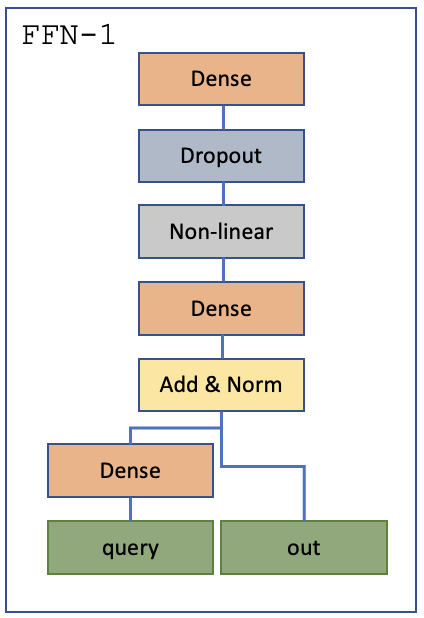

In [20]:
display(Image('FFN-1.png', width=250, height=250))

In [15]:
class FFN_1(tf.keras.layers.Layer):
    def __init__(self, d_model, dropout_rate=0.1):
        super(FFN_1, self).__init__()
        self.d_model = d_model
      
        self.dense_a = tf.keras.layers.Dense(d_model)
        self.dense_b = tf.keras.layers.Dense(d_model)
        self.dense_c = tf.keras.layers.Dense(d_model)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, query):
        ## call layer after first MHA_X
        ## x is the output of MHA_X_1
        ## query is query input to MHA_X_1 

        query = self.dense_a(query)
        x += query
        x = self.layernorm(x)
        x = self.dense_b(x)
        x = tf.nn.gelu(x)
        x = self.dropout(x)
        return self.dense_c(x)

In [22]:
ffn1 = FFN_1(30)

In [23]:
# Exmaple       
# query  = (batch_size, seq_length, embedding_dim) (20, 50, 10)
# x      = (batch_size, seq_len, d_model)          (20, 50, 30)

query = np.random.normal(size=(20, 50, 10))
x = np.random.normal(size=(20, 50, 30))
o = ffn1(x, query)

print(o.shape)

(20, 50, 30)


#### MHA-X-a

In [16]:
class MHA_X_a(tf.keras.layers.Layer):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1):
        super(MHA_X_a, self).__init__()
        self.mha = MHA_X_1(key_dim, d_model, num_heads)
        self.ffn = FFN_1(d_model, dropout_rate)

    def call(self, query, key, value, mask):
        x = self.mha(query = query, key = key, value = value, mask = mask)
        x = self.ffn(x, query)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [25]:
mhax = MHA_X_a(30, 30, 2)

In [26]:
query = np.random.normal(size=(20, 50, 84))
key = np.random.normal(size=(20, 50, 84))
value = np.random.normal(size=(20, 50, 1))

context_points = 5
mask = np.tri(50, 50, 0)
mask[:context_points, :context_points] = 1 

x = mhax(query, key, value, mask)

print(x.shape)

(20, 50, 30)


#### MHA-XY-1

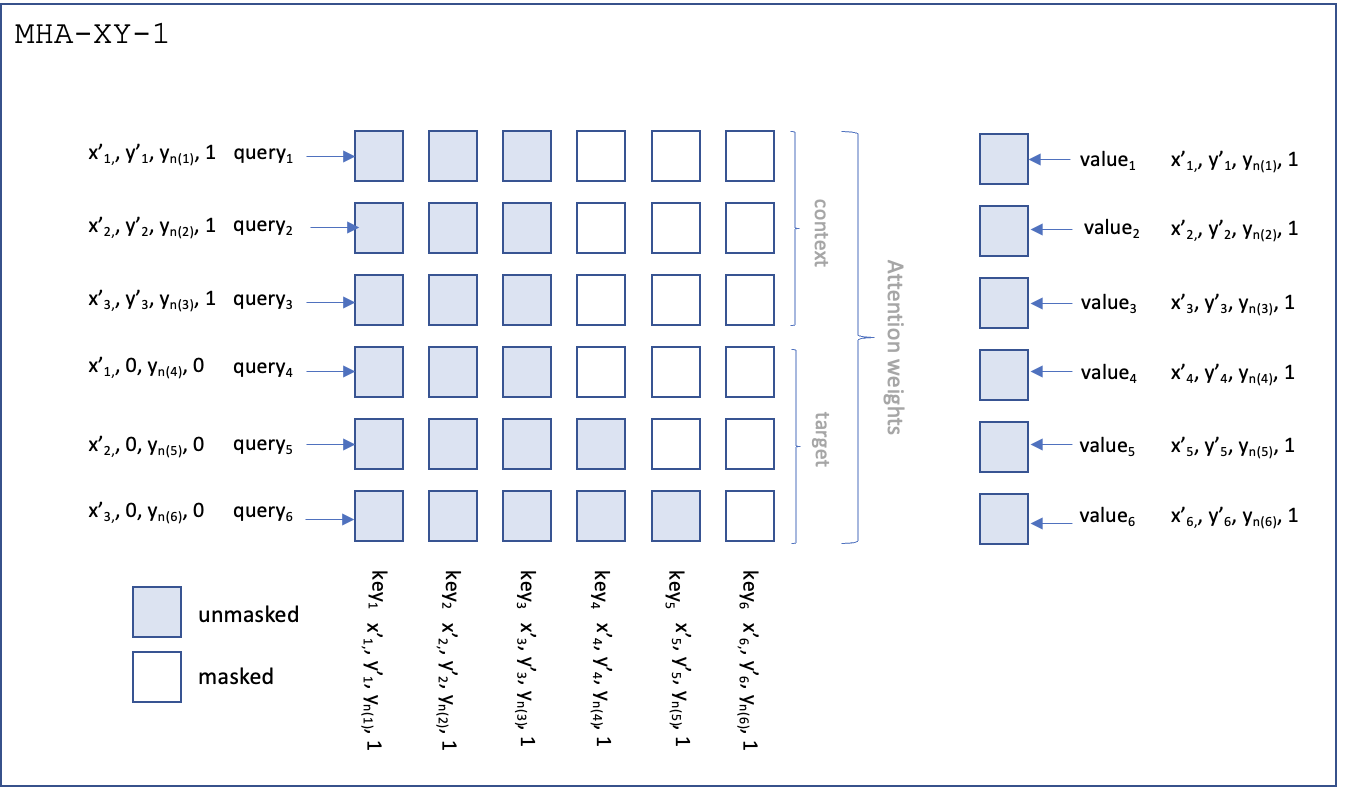

In [27]:
display(Image('MHA-XY-1.png', width=750, height=750))

In [17]:
class MHA_XY_1(tf.keras.layers.Layer):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1):
        super(MHA_XY_1, self).__init__()
        
        self.key_dim = key_dim
        self.num_heads = num_heads
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim = key_dim, num_heads=num_heads, output_shape = d_model)
        
    def call(self, query, key, value, mask):
        x = self.mha(query = query, key = key, value = value, attention_mask = mask)
        return x

In [29]:
mha_xy1 = MHA_XY_1(30, 30, 2) 

In [30]:

query = np.random.normal(size=(20, 50, 20))
key = np.random.normal(size=(20, 50, 20))
value = np.random.normal(size=(20, 50, 20))

context_points = 5
mask = np.tri(50, 50, 0)
mask[:context_points, :context_points] = 1 

x = mha_xy1(query, key, value, mask)

print(x.shape)

(20, 50, 30)


#### MHA-XY-a

In [18]:
class MHA_XY_a(tf.keras.layers.Layer):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1):
        super(MHA_XY_a, self).__init__()
        self.mha = MHA_XY_1(key_dim, d_model, num_heads)
        self.ffn = FFN_1(d_model, dropout_rate)

    def call(self, query, key, value, mask):
        x = self.mha(query = query, key = key, value = value, mask = mask)
        x = self.ffn(x, query)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [32]:
mha_xy = MHA_XY_a(30, 30, 2) 

In [33]:
query = np.random.normal(size=(20, 50, 20))
key = np.random.normal(size=(20, 50, 20))
value = np.random.normal(size=(20, 50, 20))

context_points = 5
mask = np.tri(50, 50, 0)
mask[:context_points, :context_points] = 1 

x = mha_xy(query, key, value, mask)

print(x.shape)

(20, 50, 30)


#### MHA-X-o

In [19]:
class MHA_X_o(tf.keras.layers.Layer):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1):
        super(MHA_X_o, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(key_dim = key_dim, num_heads=num_heads, output_shape = d_model)

    def call(self, query, key, value, mask):

        x = self.mha(query, key, value, mask)
        return  x

In [35]:
mhax_o = MHA_X_o(30, 30, 2)

In [36]:
query = np.random.normal(size=(20, 50, 30))
key = np.random.normal(size=(20, 50, 30))
value = np.random.normal(size=(20, 50, 1))

context_points = 5
mask = np.tri(50, 50, 0)
mask[:context_points, :context_points] = 1 

x = mhax_o(query, key, value, mask)

print(x.shape)

(20, 50, 30)


#### FFN-o

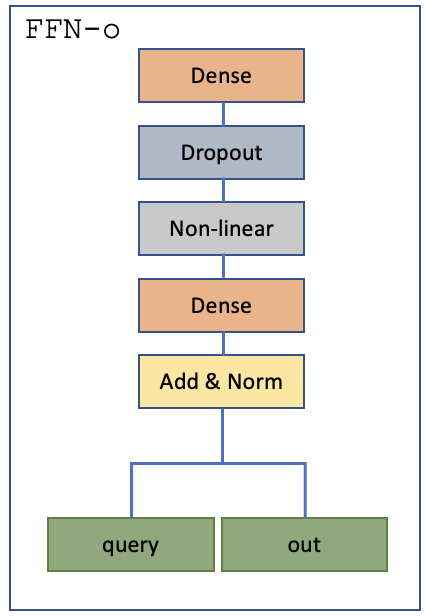

In [37]:
display(Image('FFN-o.png', width=250, height=250))

In [20]:
class FFN_o(tf.keras.layers.Layer):
    def __init__(self, d_model, dropout_rate=0.1):
        super(FFN_o, self).__init__()

        self.d_model = d_model
        self.dense_a = tf.keras.layers.Dense(d_model)
        self.dense_b = tf.keras.layers.Dense(d_model)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, query):

      ## query is the output of previous MHA_X layer
      ## x is query input to MHA_X_o 

        x += query
        x = self.layernorm(x)
        x = self.dense_a(x)
        x = tf.nn.gelu(x)
        x = self.dropout(x)
        return self.dense_b(x)

In [39]:
ffno = FFN_o(30)

In [40]:
query = np.random.normal(size=(20, 50, 30))
x = np.random.normal(size=(20, 50, 30))
o = ffno(x, query)
print(o.shape)

(20, 50, 30)


#### MHA-X-b

In [21]:
class MHA_X_b(tf.keras.layers.Layer):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1):
        super(MHA_X_b, self).__init__()
        self.mha = MHA_X_o(key_dim, d_model, num_heads)
        self.ffn = FFN_o(d_model, dropout_rate)

    def call(self, query, key, value, mask):
        x = self.mha(query = query, key = key, value = value, mask = mask)
        x = self.ffn(x, query)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [42]:
mhax_b = MHA_X_b(30, 30, 2)

In [43]:
query = np.random.normal(size=(20, 50, 30))
key = np.random.normal(size=(20, 50, 30))
value = np.random.normal(size=(20, 50, 1))

context_points = 5
mask = np.tri(50, 50, 0)
mask[:context_points, :context_points] = 1 

o = mhax_b(query, key, value, mask)
print(o.shape)

(20, 50, 30)


#### MHA-XY-o

In [22]:
class MHA_XY_o(tf.keras.layers.Layer):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1):
        super(MHA_XY_o, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(key_dim = key_dim, num_heads=num_heads, output_shape = d_model)

    def call(self, query, key, value, mask):

        x = self.mha(query, key, value, mask)
        return  x

In [23]:
class MHA_XY_b(tf.keras.layers.Layer):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1):
        super(MHA_XY_b, self).__init__()
        self.mha = MHA_XY_o(key_dim, d_model, num_heads)
        self.ffn = FFN_o(d_model, dropout_rate)

    def call(self, query, key, value, mask, prev_mha_xy_out):
        x = self.mha(query = query, key = key, value = value, mask = mask)
        x = self.ffn(x, prev_mha_xy_out)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [46]:
mha_xy_b = MHA_XY_b(30, 30, 2)

In [47]:
value = key = query = np.random.normal(size=(20, 50, 30))
prev_mha_xy_out = np.random.normal(size=(20, 50, 30))

context_points = 5
mask = np.tri(50, 50, 0)
mask[:context_points, :context_points] = 1 

o = mha_xy_b(query, query, query, mask, prev_mha_xy_out)
print(o.shape)

(20, 50, 30)


### full ATP

In [39]:
class ATP(tf.keras.Model):
    def __init__(self,
                  key_dim,
                  d_model,
                  num_heads,
                  num_layers,
                  dropout_rate=0.1):
        super(ATP, self).__init__()

        self.num_layers = num_layers
        
        self.mha_x_a = MHA_X_a(key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1)
      
        self.mha_x_b = [MHA_X_b(key_dim = key_dim, d_model=d_model, num_heads=num_heads,
                     dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.mha_xy_a = MHA_XY_a(key_dim,
                  d_model,
                  num_heads,
                  dropout_rate=0.1)
        
        self.mha_xy_b = [MHA_XY_b(key_dim = key_dim, d_model=d_model, num_heads=num_heads,
                     dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.dense_sigma = tf.keras.layers.Dense(1)
        self.dense_last = tf.keras.layers.Dense(1)



    def call(self, input, training=True):
        query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = input
        x = self.mha_x_a(query = query_x, key = key_x, value = value_x, mask = mask)
        xy = self.mha_xy_a(query_xy, key_xy, value_xy, mask)

        for i in range(self.num_layers):
            x  = self.mha_x_b[i](x, x, value_x, mask)
            xy_temp = xy[:, :]
            xy = xy + x
            xy  = self.mha_xy_b[i](xy, xy, xy, mask, xy_temp)
            if (i < (self.num_layers - 1)):
                sigma = self.dense_sigma(xy)
        z = xy

        mu = self.dense_last(z) + y_n
        return tf.concat([mu, sigma], axis=-1)


In [40]:
atp = ATP(30, 30, 2, 3)

In [50]:
# Example 
query_x = np.random.normal(size=(20, 50, 84))
key_x = np.random.normal(size=(20, 50, 84))
value_x = np.random.normal(size=(20, 50, 1))
y_n = np.random.normal(size=(20, 50, 1))

query_xy = np.random.normal(size=(20, 50, 89))
key_xy = np.random.normal(size=(20, 50, 89))
value_xy = np.random.normal(size=(20, 50, 89))

context_points = 5
mask = np.tri(50, 50, 0)
mask[:context_points, :context_points] = 1 

x = atp((query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n))

print(x.shape)

(20, 50, 2)


### Training 

In [41]:
opt = tf.keras.optimizers.Adam(3e-4)

def log_lik(y, y_hat, ϵ=0.001):
    pi = tf.constant(m.pi, dtype=tf.float32)
    real = tf.cast(y, tf.float32)
    # c = tf.cast(y_hat[0, 0, 2], tf.int32) 
    # μ, log_σ =  y_hat[:, c:, 0], y_hat[:, c:, 1]
    μ, log_σ =  y_hat[:, :, 0], y_hat[:, :, 1]

    mse_per_point = tf.math.square(tf.math.subtract(real, μ))
    lik_per_point = (1 / 2) * tf.math.divide(mse_per_point, tf.math.square(tf.math.exp(log_σ) + ϵ)) + tf.math.log(tf.math.exp(log_σ) + ϵ) + (1/2)*tf.math.log(2*pi)
    return tf.math.reduce_mean(lik_per_point)

In [42]:
atp.compile(
    loss=log_lik,
    optimizer=opt)

In [43]:
k = int((client_300["300"].shape[0]) * 0.7)
batch_s = 32

for steps in range(5):
    t, y = batcher(client_300["t"][:k], client_300["300"][:k], batch_s=batch_s)
    t, y, c, n = batch_sampler(t, y)
    query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = make_features(t, y, int(c))
    atp.fit((query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n[:, :, np.newaxis]), y)

2023-04-23 22:14:13.569007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step - loss: 37940.0391


2023-04-23 22:14:17.502005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 111771.1016


2023-04-23 22:14:19.983227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 7847.9521


In [44]:
atp.summary()

Model: "atp_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mha_x_a_2 (MHA_X_a)         multiple                  16620     
                                                                 
 mha_x_b_6 (MHA_X_b)         multiple                  7590      
                                                                 
 mha_x_b_7 (MHA_X_b)         multiple                  7590      
                                                                 
 mha_x_b_8 (MHA_X_b)         multiple                  7590      
                                                                 
 mha_xy_a_2 (MHA_XY_a)       multiple                  22440     
                                                                 
 mha_xy_b_6 (MHA_XY_b)       multiple                  9330      
                                                                 
 mha_xy_b_7 (MHA_XY_b)       multiple                  9330  

### Inference

In [46]:
t, y = batcher(client_300["t"][k:], client_300["300"][k:], batch_s=batch_s)
t, y, c, n = batch_sampler(t, y)

# Inference
y_copy = np.copy(y)
samples = []
for i in range(int(c), int(c+n)):
    query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = make_features(t, y_copy, i)
    y_hat = atp((query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n[:, :, np.newaxis]), training=False)
    current_y = np.random.normal(y_hat[:, i, 0], np.exp(y_hat[:, i, 1]) + 0.001)
    y_copy[:, i] = current_y
samples.append(y_copy)

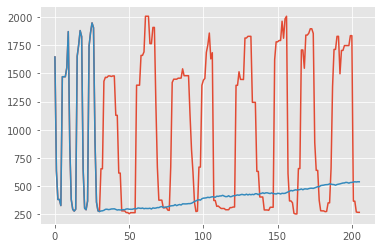

In [47]:
plt.plot(y[1, :])
plt.plot(samples[0][1, :])